In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 32

In [4]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=mnist_transform, download=True
)

Files already downloaded and verified


In [5]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.axis("off")
        # Rearrange image shape from (3, 32, 32) to (32, 32, 3)
        ax.imshow(image.permute(1, 2, 0).squeeze().numpy(), vmin=0, vmax=1)


In [6]:
import math

def round_up_to_nearest_multiple(x):
    if x <= 1:
        return 1
    return 2 ** math.ceil(math.log2(x))

round_up_to_nearest_multiple(3)

4

In [38]:
import numpy as np
import random

orig_image_size = 32
max_step_size = 4
minimum_pixelation = 2
n = 100

current_size = orig_image_size
image_size = orig_image_size
possible_ts = [[]]
t = 0
while image_size > minimum_pixelation:
    image_size = image_size - max_step_size
    new_size = max(minimum_pixelation, round_up_to_nearest_multiple(image_size))
    if new_size != current_size:
        possible_ts.append([])
        current_size = new_size
    t += 1
    possible_ts[-1].append(t)

options = random.choices(possible_ts)[0]
ts = np.random.choice(options, n)

ts

array([2, 3, 2, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 2, 2, 2, 1, 3, 1, 2,
       2, 1, 3, 3, 1, 1, 2, 3, 1, 2, 3, 2, 1, 2, 1, 3, 1, 1, 2, 1, 3, 2,
       3, 2, 3, 3, 2, 2, 1, 2, 1, 3, 1, 1, 3, 2, 2, 3, 1, 3, 3, 3, 1, 3,
       2, 1, 3, 2, 2, 3, 2, 3, 1, 3, 2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1,
       2, 3, 3, 1, 2, 2, 3, 3, 1, 3, 3, 1])

8


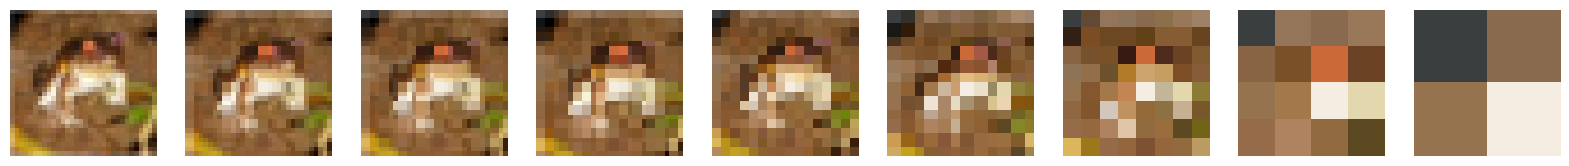

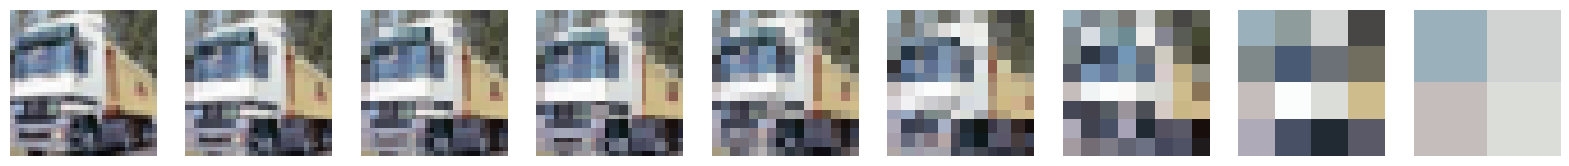

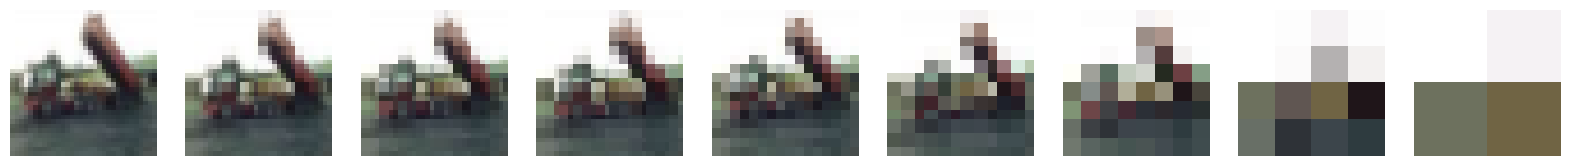

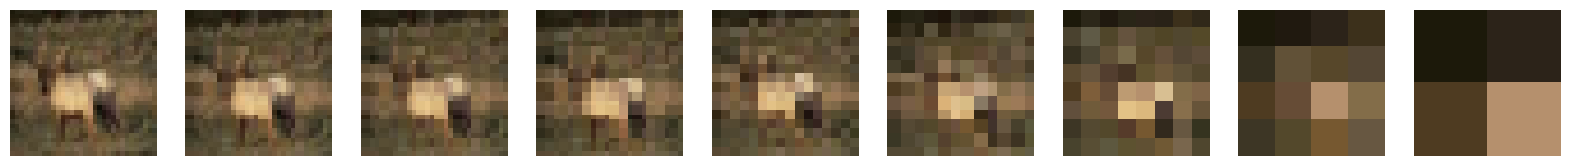

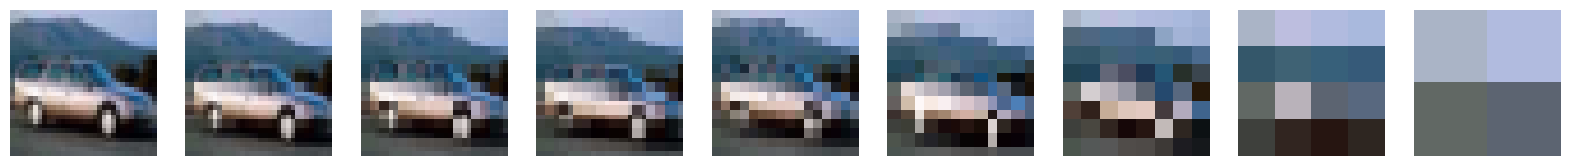

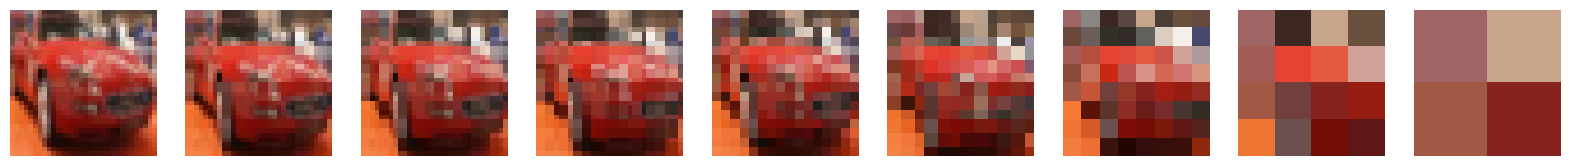

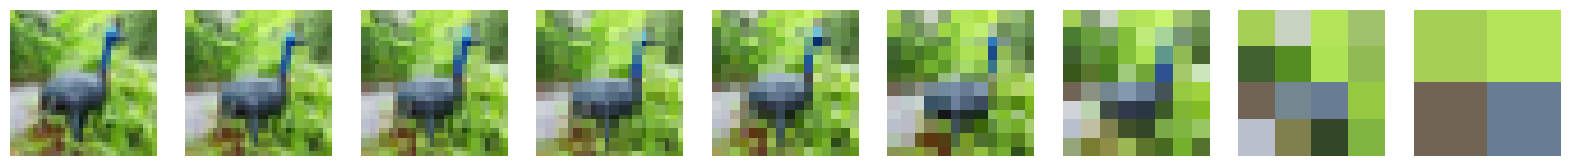

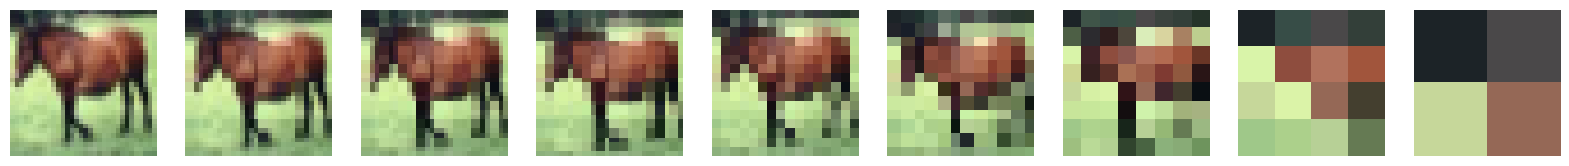

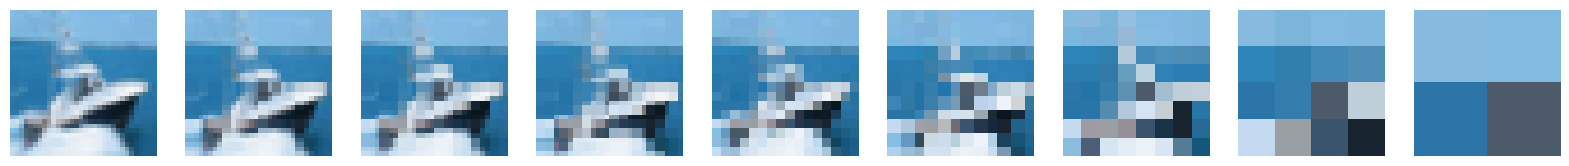

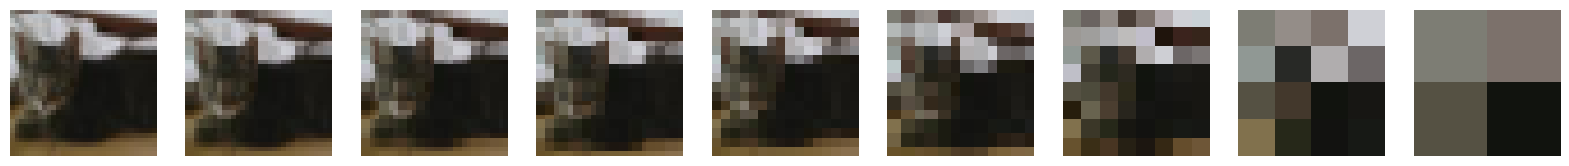

In [40]:
from utils import scale_images
import torch

class Pixelate:
    def __init__(self, max_step_size: int = 1, minimum_pixelation: int = 8) -> None:
        self.max_step_size = max_step_size
        self.minimum_pixelation = minimum_pixelation

    def calculate_T(self, image_size: int) -> int:
        """
        Calculate total number of steps based on image size and minimum pixelation.
        """
        steps = 0
        while image_size > self.minimum_pixelation:
            steps += 1
            image_size = image_size - self.max_step_size
        return steps

    def __call__(self, images: torch.Tensor, t: int) -> torch.Tensor:
        if isinstance(t, torch.Tensor):
            t = t.item()

        orig_image_size = images.shape[-1]
        target_size = max(self.minimum_pixelation, orig_image_size-self.max_step_size*t)
        image_size = max(round_up_to_nearest_multiple(max(target_size + 1, self.max_step_size)), orig_image_size)

        return scale_images(scale_images(images, to_size=target_size), to_size=image_size)


max_step_size = 4
minimum_pixelation = 2
pixelate = Pixelate(max_step_size=max_step_size, minimum_pixelation=minimum_pixelation)

T = pixelate.calculate_T(IMAGE_SIZE)
print(T)

for i in range(10):
    images = [train_dataset[i][0]]
    for t in range(1, T + 1):

        images.append(pixelate(train_dataset[i][0], t))
    showImageList(images)


In [27]:
[IMAGE_SIZE-max_step_size*t for t in range(0, T + 1)]

[32, 24, 16, 8, 0]

In [34]:
[max(minimum_pixelation, round_up_to_nearest_multiple(IMAGE_SIZE-max_step_size*t)) for t in range(0, T + 1)]

[32, 32, 16, 8, 2]

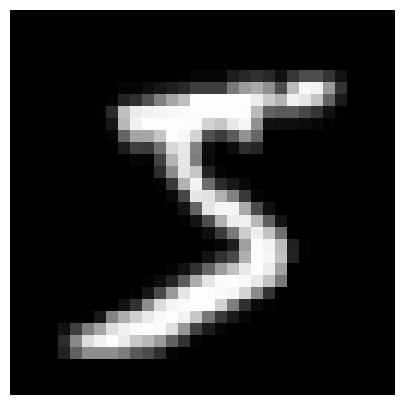

In [12]:
showImageList([pixelate(train_dataset[i][0], 0)])

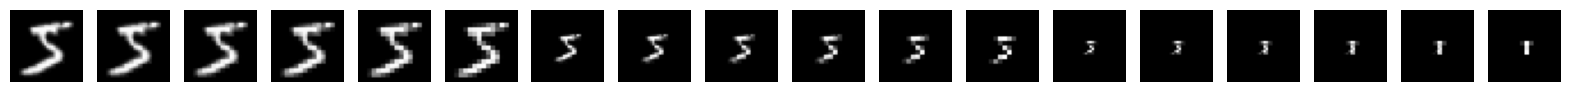

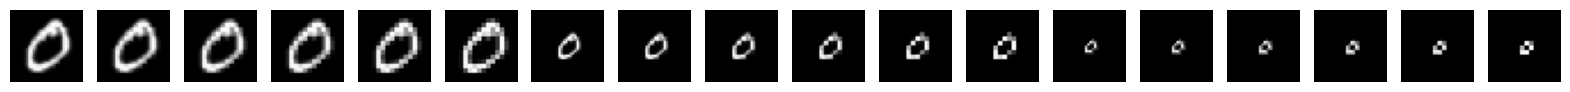

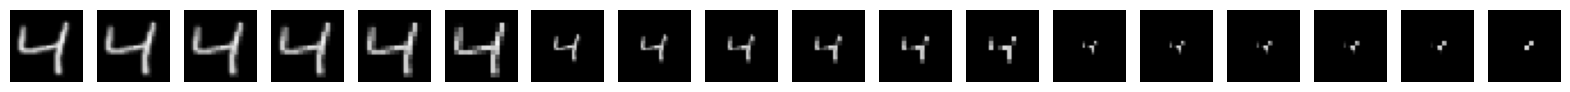

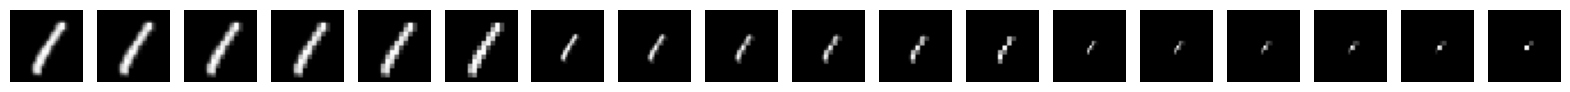

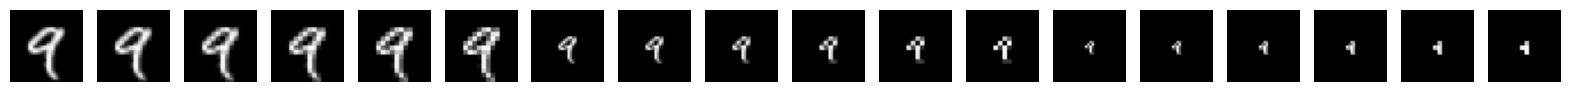

In [13]:
max_step_size = 5
minimum_pixelation = 4
pixelate = Pixelate(max_step_size=max_step_size, minimum_pixelation=minimum_pixelation)
from utils import scale_images
import math


def get_image_time_line(image):
    images = []
    initial_size = image.shape[-1]


    number_of_levels = int(math.log2(initial_size) - math.log2(minimum_pixelation * 2)) + 1

    
    for level in range(0, number_of_levels):
        for relative_t in range(1, max_step_size + 2):
            # Downscale image
            to_size = initial_size // (2 ** level)
            scaled_image = scale_images(image.unsqueeze(0), to_size)

            # Pixelate image
            pixelated_image = pixelate(scaled_image, relative_t)

            # Pad image
            pad_size = initial_size - pixelated_image.shape[-1]

            pixelated_image = torch.nn.functional.pad(
                pixelated_image,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(pixelated_image)

    return images


for i in range(5):
    showImageList(
        get_image_time_line(train_dataset[i][0])
    )

In [14]:
int(math.log2(32) - math.log2(4))

3

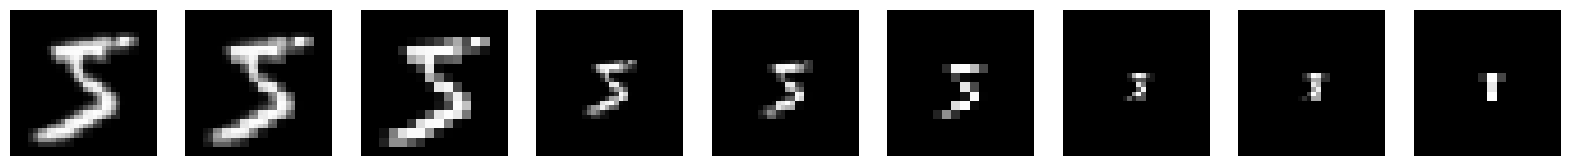

In [15]:

minimum_pixelation = 4
max_step_size = 2
pixelate = Pixelate(max_step_size=max_step_size, minimum_pixelation=minimum_pixelation)

T = pixelate.calculate_T(IMAGE_SIZE)

def get_example_sample(image):

    image = image.unsqueeze(0)

    current_size = minimum_pixelation * 2

    x_t = scale_images(image, to_size=minimum_pixelation)
    x_t = scale_images(image, to_size=current_size)

    initial_size = image.shape[-1]

    images = []

    
    while current_size <= initial_size:
        for relative_t in range(max_step_size + 1, 0, -1):

            if relative_t == max_step_size + 1:
                x_t = pixelate(x_t, relative_t)

            pad_size = initial_size - x_t.shape[-1]

            padded_image = torch.nn.functional.pad(
                x_t,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(padded_image)

            x_0 = scale_images(image, current_size)

            # x_t = (
            #         x_t
            #         - pixelate(x_0, (relative_t))
            #         + pixelate(x_0, (relative_t - 1))
            #     )
            x_t = pixelate(x_0, relative_t - 1)

            if relative_t - 1 == 0:
                current_size *= 2
                x_t = scale_images(x_t, current_size)

    return images[::-1]

for i in range(1):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )

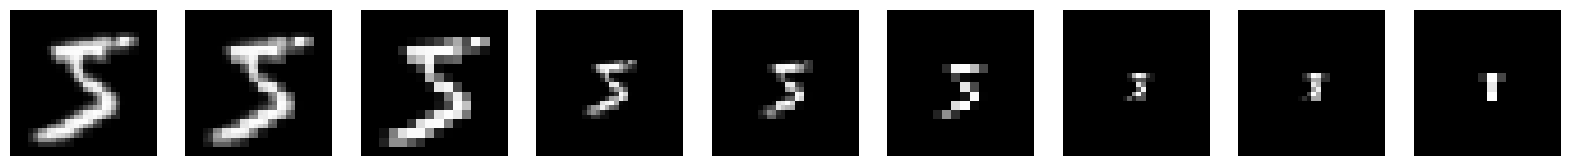

In [16]:
def get_example_sample(image):

    image = image.unsqueeze(0)

    current_size = minimum_pixelation * 2

    x_t = scale_images(image, to_size=minimum_pixelation)
    x_t = scale_images(x_t, to_size=current_size)

    initial_size = image.shape[-1]

    pad_size = initial_size - x_t.shape[-1]

    padded_image = torch.nn.functional.pad(
        x_t,
        pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
    )

    images = [padded_image]

    
    while current_size <= initial_size:
        for relative_t in range(max_step_size + 1, 0, -1):

            x_0 = scale_images(image, current_size)

            x_t = (
                    x_t
                    - pixelate(x_0, relative_t)
                    + pixelate(x_0, (relative_t - 1))
                )

            if relative_t - 1 == 0:
                current_size *= 2
                x_t = scale_images(x_t, current_size)
                

            

            pad_size = initial_size - x_t.shape[-1]

            padded_image = torch.nn.functional.pad(
                x_t,
                pad=(pad_size // 2, pad_size // 2, pad_size // 2, pad_size // 2),
            )

            images.append(padded_image)

    # remove last image
    images = images[:-1]


    return images[::-1]

for i in range(1):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )

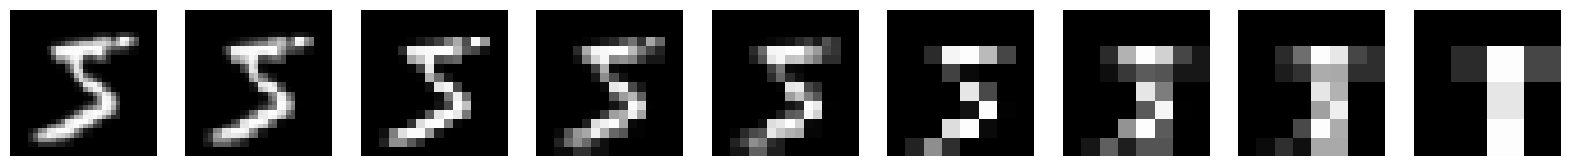

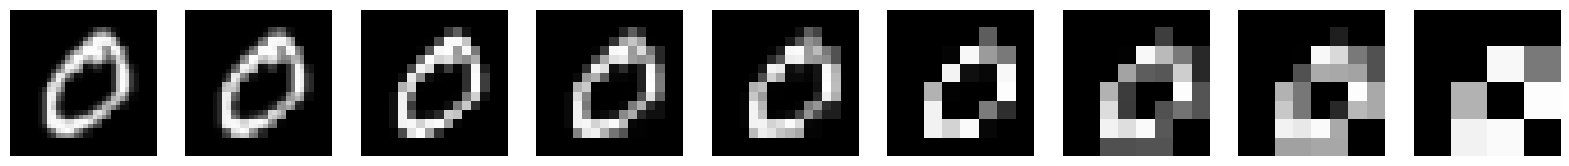

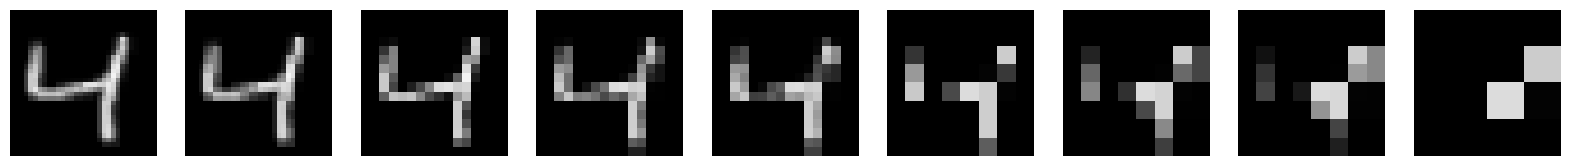

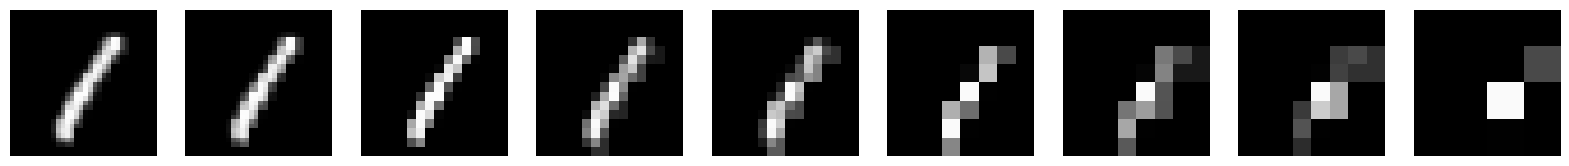

In [17]:

def get_example_sample(image):

    image = image.unsqueeze(0)

    x_t = pixelate(image, T)

    images = [x_t]

    for t in range(T, 1, -1):

        x_t = (
            x_t
            - pixelate(image, t)
            + pixelate(image, (t - 1))
        )
        # x_t = pixelate(image, (t - 1))

        images.append(x_t)


    return images[::-1]

T = pixelate.calculate_T(IMAGE_SIZE)
for i in range(4):
    showImageList(
        get_example_sample(train_dataset[i][0])
    )

In [27]:
class ArithmeticScheduler():
    def get_probabilities(self, number_of_levels):
        prob_dist = [i for i in range(1, number_of_levels + 1)]
        return [p / sum(prob_dist) for p in prob_dist]
    
class PowerScheduler():
    def get_probabilities(self, number_of_levels, power=0.4):
        prob_dist = [i**power for i in range(1, number_of_levels + 1)]
        return [p / sum(prob_dist) for p in prob_dist]
    
class GeometricScheduler():
    def get_probabilities(self, number_of_levels, base=1.5):

        prob_dist = [base**i for i in range(number_of_levels)]
        return [p / sum(prob_dist) for p in prob_dist]
    
from math import comb

class BinomialScheduler():
    def __init__(self, probability_of_success):
        self.probability_of_success = probability_of_success
    
    def get_probabilities(self, number_of_levels):
        n = number_of_levels - 1  # n trials for n+1 levels
        p = self.probability_of_success
        prob_dist = [comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(number_of_levels)]
        # Normalize the probabilities so they sum to 1
        total = sum(prob_dist)
        normalized_prob_dist = [p / total for p in prob_dist]
        return normalized_prob_dist

    

geometric = GeometricScheduler()
arithmetic = ArithmeticScheduler()
power = PowerScheduler()
binomial_scheduler = BinomialScheduler(probability_of_success=0.6)
t = 3
print(f'Geometric: {geometric.get_probabilities(t, base=0.6)}')
print(f'Arithmetic: {arithmetic.get_probabilities(t)}')
print(f'Power: {power.get_probabilities(t, power=0.5)}')
print(f'Binomial: {binomial_scheduler.get_probabilities(t)}')

Geometric: [0.5102040816326531, 0.30612244897959184, 0.1836734693877551]
Arithmetic: [0.16666666666666666, 0.3333333333333333, 0.5]
Power: [0.24118095489747923, 0.34108137740210887, 0.4177376677004118]
Binomial: [0.16000000000000003, 0.48, 0.36]
